# Chime Case Study
Ravi Dayabhai

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [45]:
# Import dependencies
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import sem, beta, binom, mstats
from statsmodels.stats.proportion import proportions_ztest
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
import pymc3 as pm

# Custom code
from helpers.load import df_perf, df_acq_agg, df_acq_segment
from helpers.viz import bps
from helpers.cohort import (control, test, control_A, control_B, test_A, test_B)

## Data Load / Processing

Luckily, these data are super clean and relatively small. Conversion to CSVs ensured data type integrity and these toy data contain no nulls. (See `helpers.load` for more information.)

## EDA

The exploratory data analysis will largely be driven by the questions extracted from the case study prompt.

**Notes**:

- For the The _Treatment_, in this context, comprises a customer journey featuring a spend tracker, wherease the _Control_ arm is not availed of the existence of a spend tracker.
- Average monthly spend for Segment B is _higher_ than Segment A's.
- Members in Segment B are _more likely_ to have additional bank accounts in addition to Chime.
- The Spend Tracker is free _to all members_ and will cost Chime \$5 per member per month (PMPM), i.e., it is not revenue generating itself.

### Acquisition

- What does the funnel look like for Control vs. Treatment?
- Assuming cogent data collection, did the Treatment drive lift in CTR? Conversions?
- Segment A vs. Segment B: are the distributions of converted users different in each variant?
- How does overall CAC compare for Control vs. Treatment?

In [3]:
# Show funnel
df_acq_agg

,Spend,Population,Unique Clicks,Conversions,CTR,Click CR,User CR,CPUC,CAC
Variant,,,,,,,,,
Test,1020581,20214295,208206,23007,0.0103,0.110501,0.001138,4.901785,44.359586
Control,1010476,20014153,200140,19815,0.0100,0.099006,0.000990,5.048846,50.995508


In [4]:
df_acq_segment 

,Segment A,Segment B,Total
Variant,,,
Test,10504,12503,23007
Control,9906,9909,19815


#### Experimental Analysis: User Conversions

We'll start with a Frequentist's approach following the traditional null hypothesis signifance testing model.

We ultimately care about the conversion lift generated by advertising Chime's product _with_ the spend tracker vs. Control condition. Stated formally,

$$
H_{0}: p_{T} - p_{C} = 0\\
H_{a}: p_{T} - p_{C} > 0
$$

where $p_{T}$ and $p_{C}$ are the proportion of converted users in the Treatment and Control populations, respectively. The significance level, $\alpha$ for this test is set to $0.05$.


In [5]:
# Set significance level
alpha = 0.05

# Calculate test statistics, p-value for User CR
user_CR_test_stat, user_CR_p_value = proportions_ztest(
    count=df_acq_agg['Conversions'], 
    nobs=df_acq_agg['Population'], 
    alternative='larger'
)

print(f"User Conversion Rate p-value: {user_CR_p_value}; statistically significant? {user_CR_p_value < alpha}")

# Calculate test statistics, p-value for CTR
CTR_test_stat, CTR_p_value = proportions_ztest(
    count=df_acq_agg['Unique Clicks'], 
    nobs=df_acq_agg['Population'], 
    alternative='larger'
)

print(f"Click-thru-rate (CTR) p-value: {CTR_p_value}; statistically significant? {CTR_p_value < alpha}")

User Conversion Rate p-value: 2.460543238137127e-47; statistically significant? True
Click-thru-rate (CTR) p-value: 1.1368573134571388e-21; statistically significant? True


Both CTR and User CR are far below our significance level, indicating that the lift we're seeing is statistically significant. On a practical level, the c. 200 bps different in conversion rate is non-trivial (as we'll see when I turn my attention to the unit economics of the variants)!

#### Converted Users: Segment Distributions

I want to investigate whether the Treatment shifted the distribution of users (by segment) relative to Control. Let's visualize the segment distributions by variant:

In [6]:
# Break out data for standard errors, means
test_user_segmented = np.concatenate((np.zeros(df_acq_segment.loc['Test', 'Segment A']),
                                      np.ones(df_acq_segment.loc['Test', 'Segment B'])), 
                                     axis=0)

control_user_segmented = np.concatenate((np.zeros(df_acq_segment.loc['Control', 'Segment A']),
                                         np.ones(df_acq_segment.loc['Control', 'Segment B'])), 
                                        axis=0)

# Sample stats, proportion of Segment B user conversions
test_std_error = sem(test_user_segmented)
control_std_error = sem(control_user_segmented)
test_mean = test_user_segmented.mean()
control_mean = control_user_segmented.mean()

print(f"Mean (Proportion of Segment B User Conversions, Test): {test_mean}")
print(f"Mean (Proportion of Segment B User Conversions, Control): {control_mean}")
print(f"SE (Proportion of Segment B User Conversions, Test): {test_std_error}")
print(f"SE (Proportion of Segment B User Conversions, Control): {control_std_error}")

test_mean - control_mean

Mean (Proportion of Segment B User Conversions, Test): 0.5434432998652584
Mean (Proportion of Segment B User Conversions, Control): 0.5000757002271007
SE (Proportion of Segment B User Conversions, Test): 0.0032840058487101113
SE (Proportion of Segment B User Conversions, Control): 0.0035520896644976245


0.04336759963815773

The observed data suggests a MLE difference (which we'll refer to as $\Delta$) of roughly 430 bps.

Unsurprisingly, the standard errors of the estimate of the true proportion of Segment B user conversions in each variant is tiny (given large $n$).

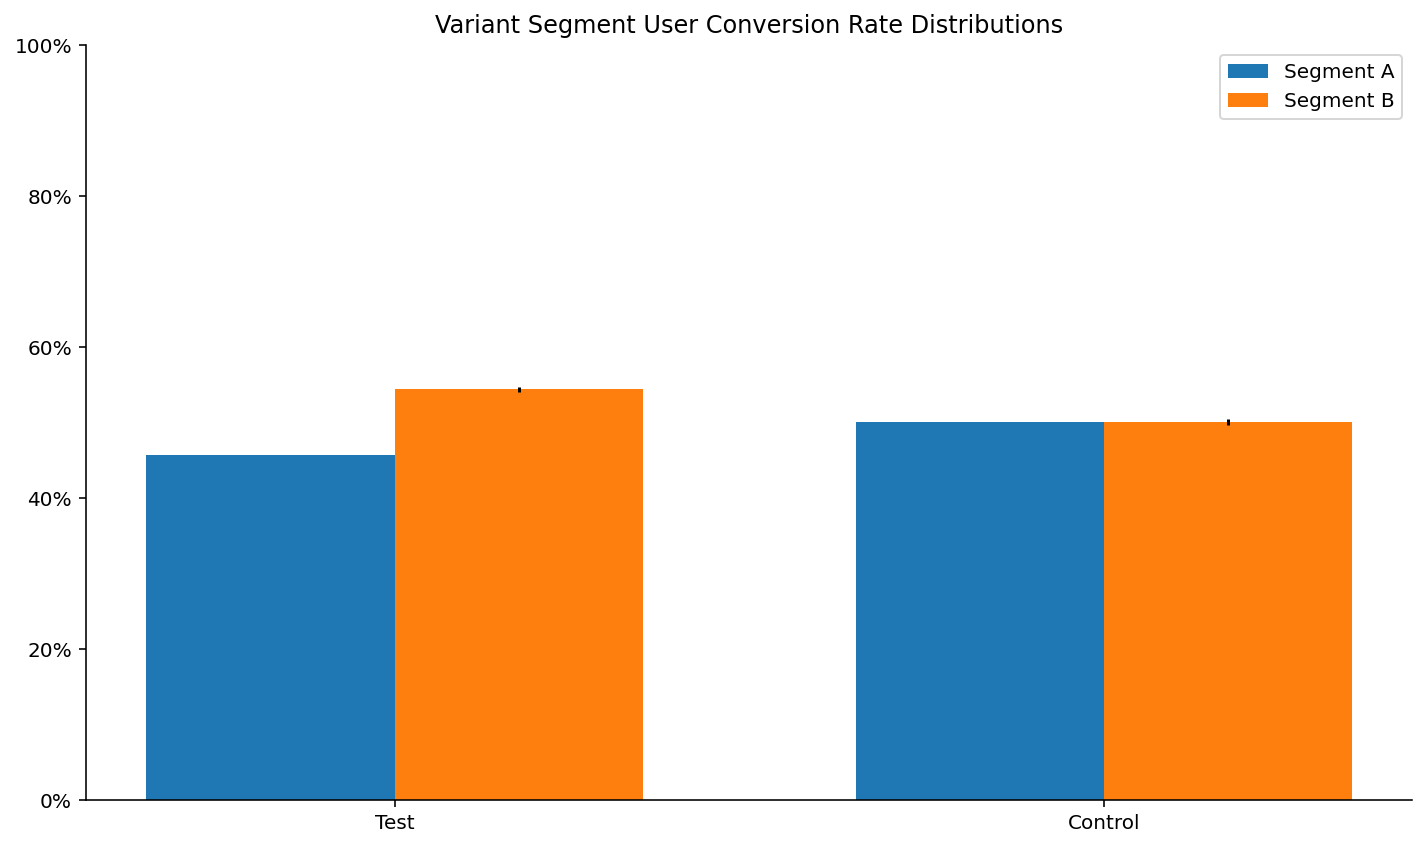

In [7]:
# Set up plots
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
xs = np.array([0, 1])
width = .35

# Plot data
ax.bar(xs, height=df_acq_segment['Segment A'] / df_acq_segment['Total'], 
       width=width, label='Segment A')
ax.bar(xs + width, height=df_acq_segment['Segment B']  / df_acq_segment['Total'], 
       width=width, label='Segment B', yerr=[test_std_error, control_std_error])

# Cosmetic adjustments
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Variant Segment User Conversion Rate Distributions')
ax.set_xticks(xs + width / 2)
ax.set_xticklabels(['Test', 'Control'])
ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Show plot
plt.legend()
plt.tight_layout()
plt.show()


A Bayesian approach seems particularly apt here, since the conditional segment distributions are characterized by $p_{B|i}, i \in \{C, T\}$, probability of a converted user being a Segment B user given a particular variant. We don't know these ahead of time, but our experiment has provided data that we can apply to our prior beliefs about what these parameters might be.

Using flat prior, we can determine the posterior distribution given the data we actually observed. Simulating from this distribution will allow us to make statements about how and to what degree we expect the spend tracker feature to impact the distribution of user conversion. We'll leverage the beta-binomial conjugacy to keep the prior and posterior in the same family of distributions.

In [8]:
# Simulate outcomes from posterior distributions
N = 20_000
with pm.Model() as model:
    
    # Uninformed priors (standard uniform)
    p_control = pm.Beta('control', 1, 1)
    p_test = pm.Beta('test', 1, 1)
    
    # Deterministic difference function
    delta = pm.Deterministic("delta", p_test - p_control)

    # Set of observations, in this case we have two observation datasets.
    obs_test = pm.Bernoulli("obs_test", p_test, observed=test_user_segmented)
    obs_control = pm.Bernoulli("obs_control", p_control, observed=control_user_segmented)
    
    # Run simulation
    trace = pm.sample(N, return_inferencedata=False)
    burned_trace = trace[1000:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [test, control]


Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 44 seconds.


In [9]:
# Get data
plot_data = {}
plot_data['p_control_samples'] = burned_trace['control']
plot_data['p_test_samples'] = burned_trace['test']
plot_data['delta_samples'] = burned_trace['delta']

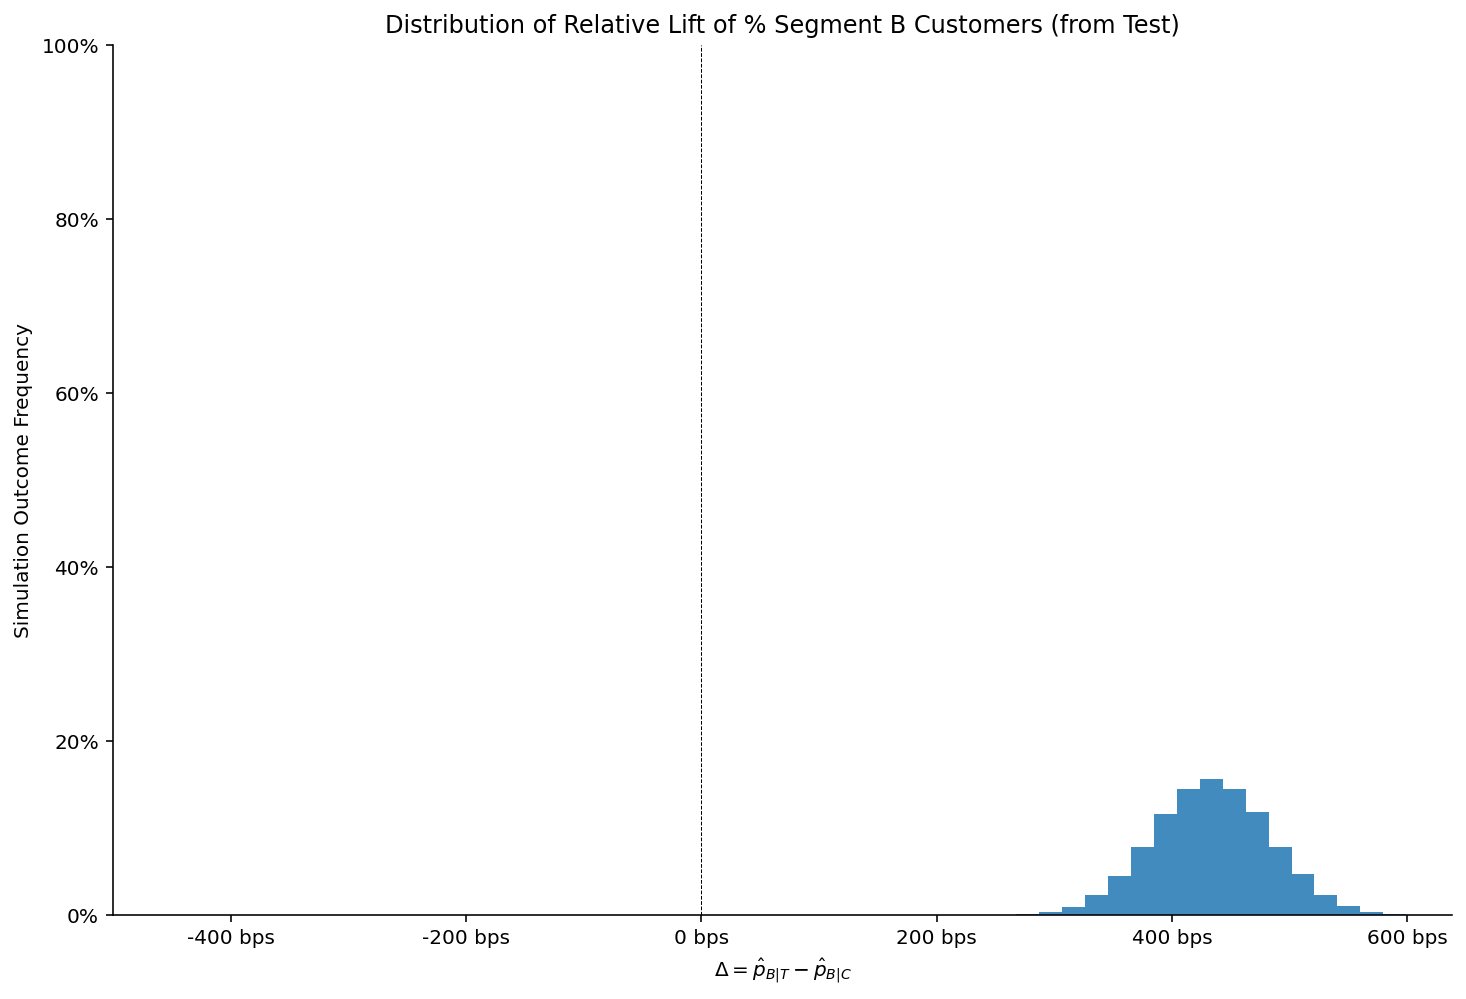

In [10]:
# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
delta_samples = plot_data['delta_samples']
bins = 20
weights = np.ones_like(delta_samples) / float(len(delta_samples))
plt.hist(delta_samples, bins=bins, weights=weights, 
         alpha=0.85, histtype='stepfilled')

# Cosmetic adjustments
plt.xlim(left = -0.05)
plt.ylim(0, 1)
plt.title('Distribution of Relative Lift of % Segment B Customers (from Test)')
plt.ylabel('Simulation Outcome Frequency')
plt.xlabel('$\Delta = \hat{p}_{B|T} - \hat{p}_{B|C}$')
plt.vlines(0, 0, 1, color='black', ls='--', lw=0.5)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_formatter(bps)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Show plot
plt.show()

In [11]:
# Summarize outcomes
print(f"P(Test produces relatively FEWER Segment B customers): {np.mean(delta_samples < 0)}")
print(f"P(Test produces relatively MORE Segment B customers): {np.mean(delta_samples > 0)}")

print(f"P(Test lift is 4% or MORE): {np.mean(delta_samples > 0.04)}")

P(Test produces relatively FEWER Segment B customers): 0.0
P(Test produces relatively MORE Segment B customers): 1.0
P(Test lift is 4% or MORE): 0.7521184210526316


Unsurprisingly, the $p$-value analogue in this context (i.e., $P(\Delta < 0)$) is vanishingly small. With roughly 75% probability, the lift (in relative proportion of Segment B users vs. Segment A users) is greater than 4%.

### Profitability

I begin this section by discussing my approach to modeling LTV.

#### LTV Calculation

There is no one way to calculate customer Lifetime Value (LTV)[1] and the various components of the metric are thorny for a whole host of reasons in a _non-contractual_ setting (like Chime's). For this exercise, I begin with the premise:

$$
E(\text{LTV}) = \sum_{t=0}^{\infty} \frac{E(m_{t}) S(t)}{(1 + d)^{t}} 
$$

where $S(t)$ represents the probability a client survives at least until time $t$ and $E(m_{t})$ is the expected contribution margin (in currency units) at time $t$. The discount factor, $\frac{1}{(1 + d)^{t}}$ simply discounts these cashflows appropriately. 

For the particular problem at hand, I'm using the observed data on hand as a point estimates for contribution margin through time $t=18$ (months) and estimating $S$ with a parametric model, $\hat{S}$ so I can:

1. Report expected lifetimes, i.e., $E(T_{i}) = \int_{0}^{\infty} \hat{S}(t_{i})\, dt$ for customers in cohort $i$ and 
2. Produce $\hat{h}(t)$, the hazard rate at time $t$, which will help determine the terminal LTV.

I calculate terminal LTV as a residual value perpetuity based on the parameterized hazard and terminal contribution margin, resulting in our operationalized model for LTV:

$$
\hat{E}(\text{LTV}) = \sum_{t=0}^{18} \frac{m_{t} \hat{S}(t)}{(1 + d)^{t}} + \frac{\hat{m}_{\text{terminal}}\hat{h}_{\text{terminal}}}{(1 + d - \hat{h}_{\text{terminal}})(1 + d)^{18}}
$$

Fitting a survival function for our data will yield $\hat{h}$ (again, assumed to be constant) and $\hat{S}$, leaving free variables $d$ and $\hat{m}_{\text{terminal}}$ for us vary. Running the model under various assumptions will give us a distribution of reasonable outcomes (a form of sensitivity analysis). (Time permitting, this can be further decomposed into each of the free variables' constituent parts.)

Below, I discuss more about the assumptions made to arrive at an estimate of LTV.

[1]: http://brucehardie.com/notes/033/what_is_wrong_with_this_CLV_formula.pdf
[2]: http://brucehardie.com/notes/024/reconciling_clv_formulas.pdf

##### Contribution Margin, $m$

I include the spend tracker per member per month cost as an ongoing "maintaince" cost amortized over all active users in the month because the cost is generated only for members that _use_ the tracker.

$$
E(m_{t}) = \underbrace{\frac{\text{Total Purchase Dollars}_{t} \times (\text{Interchange} - \text{COGS})}{\text{Active Users}_{t}}}_{\text{Gross Profit per Active User}} - \left(\frac{\overbrace{5}^{\text{Cost per Spend Tracker User}} \times \text{Spend Tracker Active User Count}_{t}}{\text{Active User Count}_{t}}\right)
$$

#### Assumptions: Point Estimates

I only have on observation of the values of the key inputs into the formula above and I am using essentially point estimates in calculating expected customer lifetime value. If I had more time, it would be interesting to simulate from inferred distributions to see the distributions of possible LTVs.

#### Assumptions: Retention

In order to proceed with any sort of calculation in this non-contractual setting, we have to make some sort of assumption regarding _retention_. We do not have data on the recency, frequency, or monetary value (RFM) at an individual level, so (to make do with the data  we have) **we will assume that Active User retention stands in for overall customer retention**.

Implicitly, by equating Active User retention to overall customer retention, we're making the statement, "The absence of purchasing by a customer means they have decided to end their 'relationship' with the Chime," rather than entertaining the notion that they intend (or will) transact again and we just haven't seen a transaction in the time period $t$ of interest.

> One can talk about a repeat-buying rate, but that has nothing in common with a retention rate — it simply reflects the “presence/absence” of purchasing activities as opposed to the observed “survival/death” that is associated with the notion of a contractual relationship.[1] 

**Making this assumption will generally bias LTV _down_, making our estimates more conservative**; because the LTV estimate plays the role of providing a ceiling for how much we'd be willing to spend to acquire a desired customer, the risk we take is _under_-investing.

[1]: http://brucehardie.com/notes/033/what_is_wrong_with_this_CLV_formula.pdf

#### Assumptions: Discount Factor, $d$

I don't have a very well informed prior for monthly discount rate, $d$, so I assume a naïve 1% monthly discount rate by default.

##### Estimated Survival Function, $\hat{S}$

A visual inspection of the observed survival (read: retention) curves (plotted here using the non-parametric, Kaplan-Meier estimator) shows that the monthly risk of churn dimishes markedly after the 1 year mark. Fitting **a piecewise exponential** model to each cohort's survival data (with a breakpoint $\tau = 12$) will let us estimate the terminal hazard rate, $\hat{h}_{\text{terminal}}$ for the cohort.

In [12]:
# Create containing structure for cohorts
cohort_two_levels = OrderedDict()
cohort_two_levels[(0,0)] = control_A
cohort_two_levels[(0,1)] = control_B
cohort_two_levels[(1,0)] = test_A
cohort_two_levels[(1,1)] = test_B

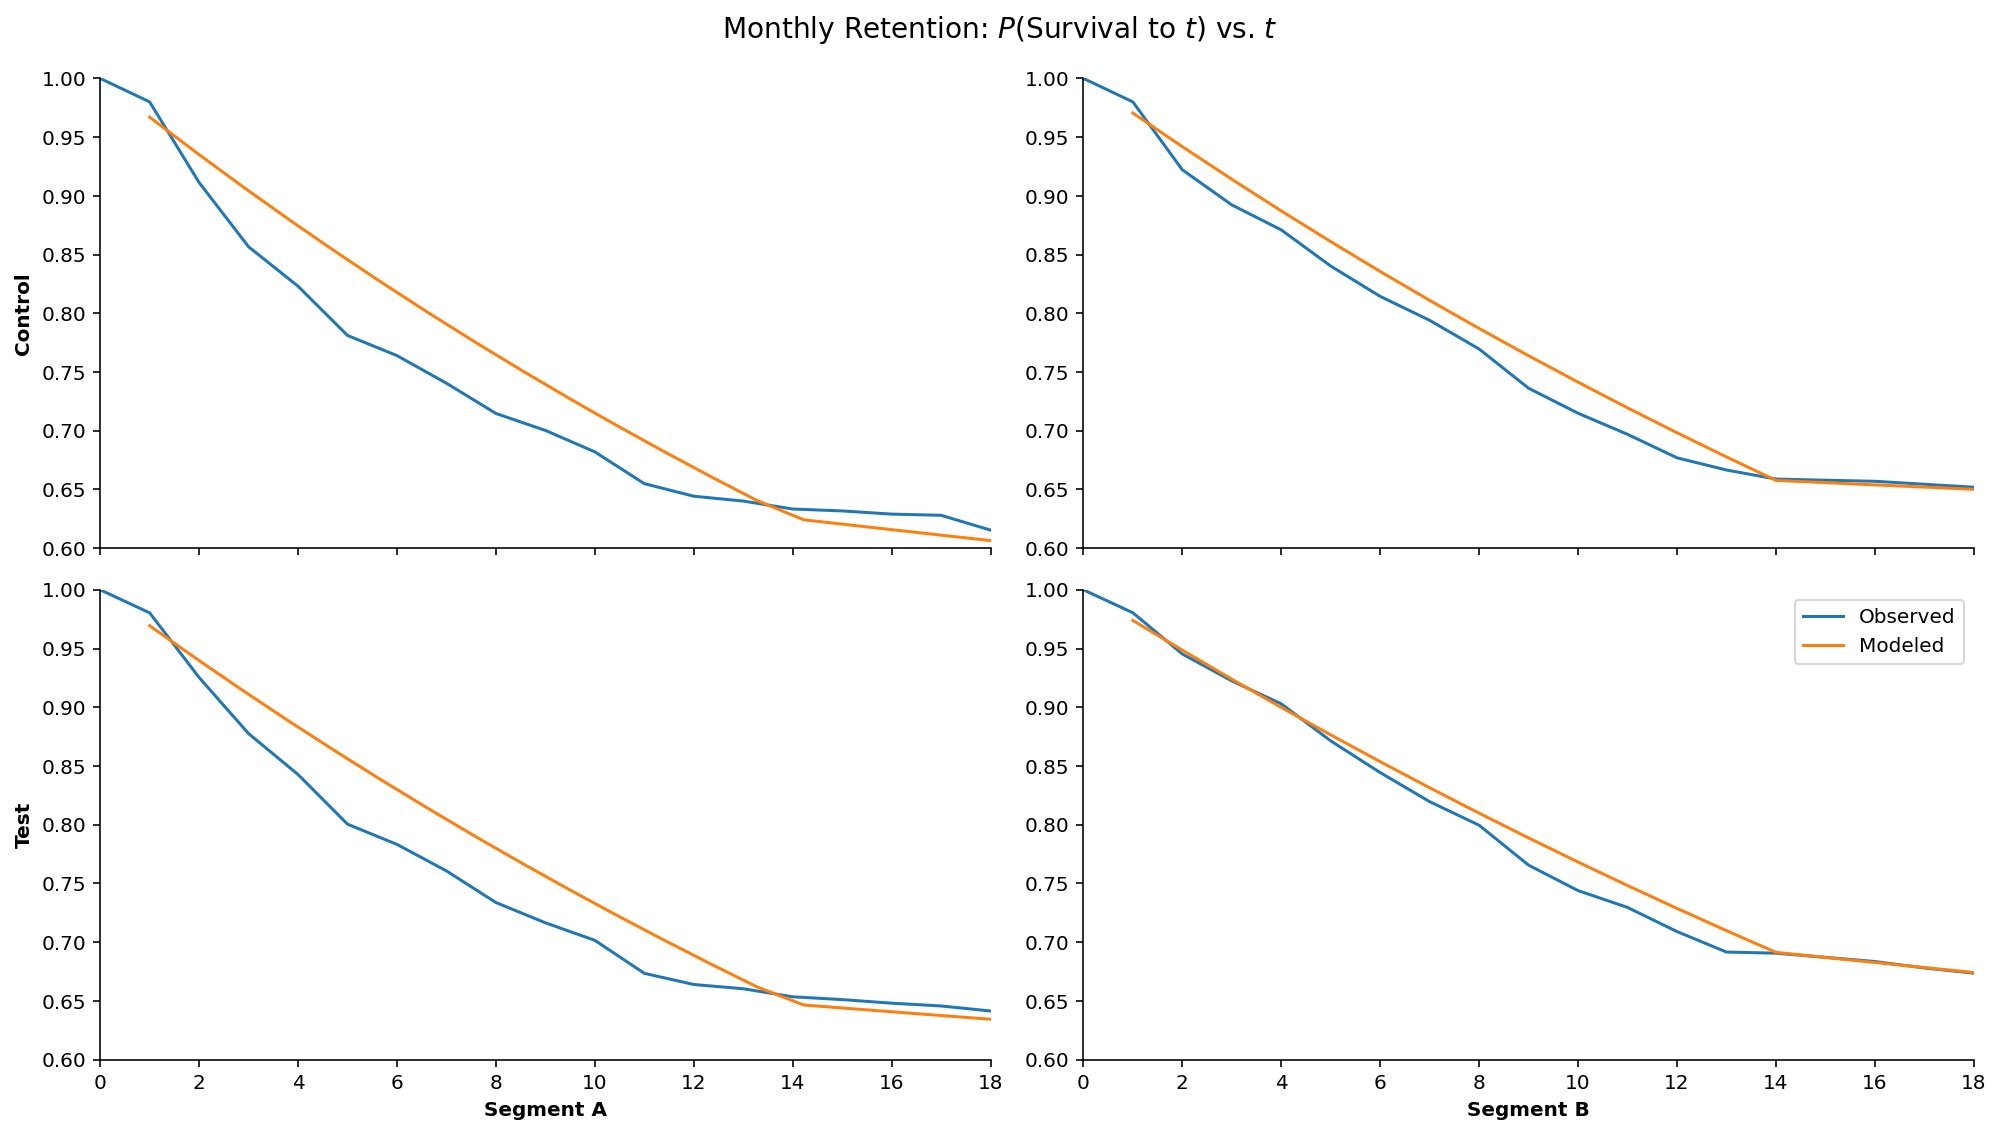

In [34]:
# Set up plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Plot data
for k, v in cohort_two_levels.items():
    i, j = k[0], k[1]
    model_kmf = v.fit_survival_model('KaplanMeier')
    model_pwexpo = v.fit_survival_model()
    axes[i][j].plot(model_kmf.survival_function_, label='Observed')
    axes[i][j].plot(model_pwexpo.survival_function_, label='Modeled')
    
    # Cosmetic adjustments
    axes[i][j].spines['top'].set_visible(False)
    axes[i][j].spines['right'].set_visible(False)
    axes[i][j].set_xlim(0, 18)
    axes[i][j].set_ylim(0.6, 1)
    
    if i == 0 and j == 0:
        axes[i][j].set_ylabel('Control', fontweight='heavy', fontsize=10)
    if i == 1 and j == 0:
        axes[i][j].set_ylabel('Test', fontweight='heavy', fontsize=10)
        axes[i][j].set_xlabel('Segment A', fontweight='heavy', fontsize=10)
    if i == 1 and j == 1:
        axes[i][j].set_xlabel('Segment B', fontweight='heavy', fontsize=10)
        
plt.suptitle('Monthly Retention: $P($Survival to $t)$ vs. $t$', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**Hypothesis**: The spend tracker helps overall profitability by driving more cumulative spending per member over their lifetime. The lift in profitability can be decomposed into:
- Incremental profitability due to _higher retention per member_.
- Incremental profitability due to _higher avergage monthly spend per member_.

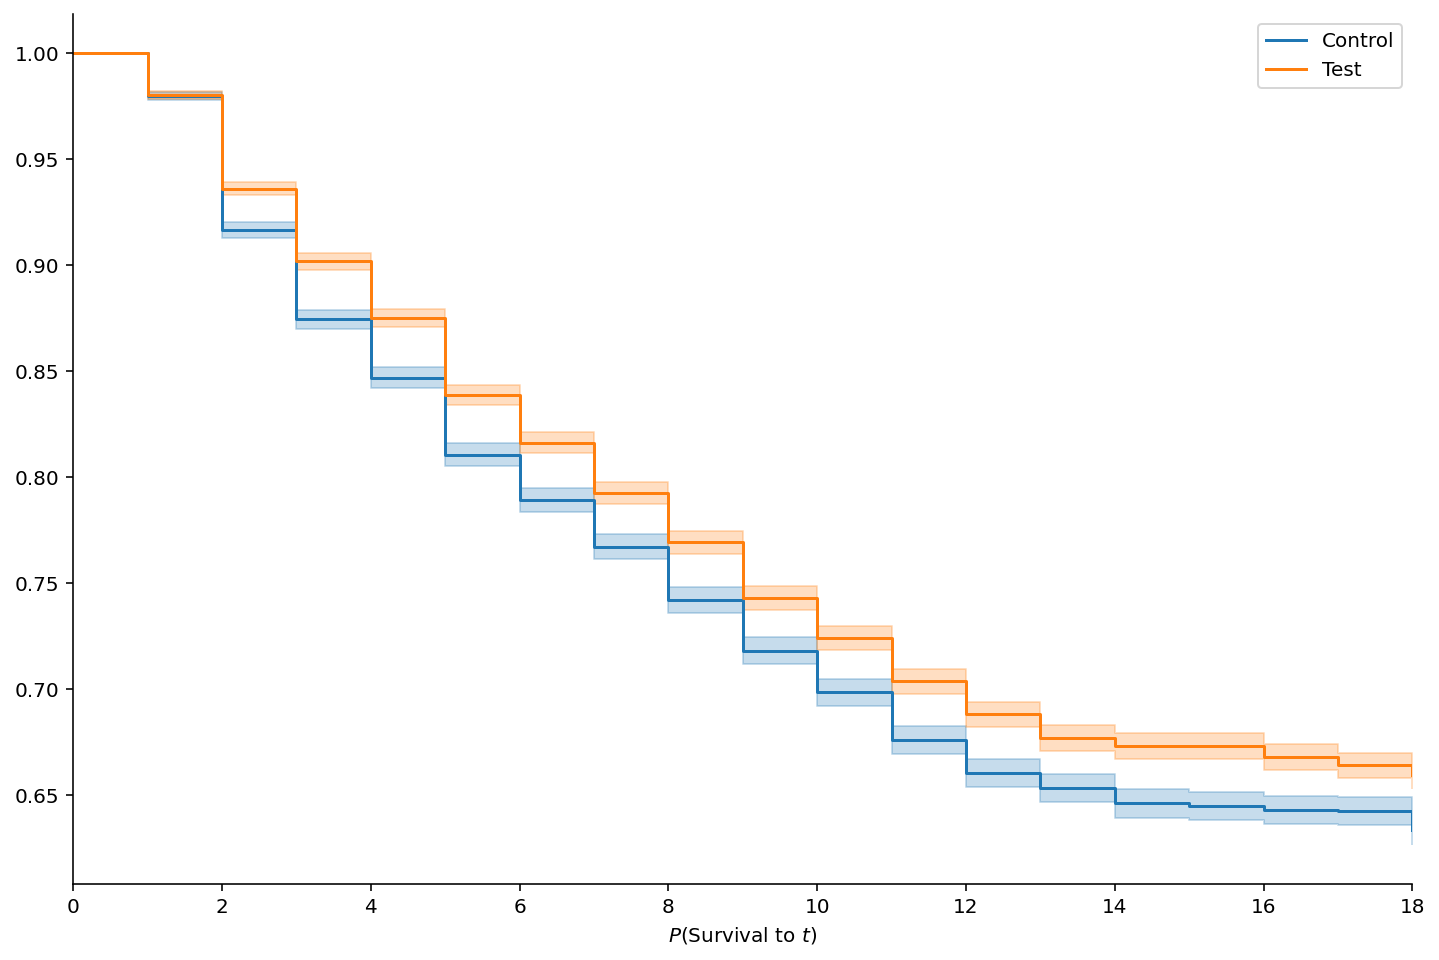

In [44]:
# Plot Test vs. Control retention overall
test_model = test.fit_survival_model('KaplanMeier', label='Test')
control_model = control.fit_survival_model('KaplanMeier', label='Control')

# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
control_model.plot_survival_function()
test_model.plot_survival_function()

# Cosmetic Adjustments
plt.xlabel('Months Since Conversion')
plt.xlabel('$P($Survival to $t)$')
plt.xlim(0, 18)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [51]:
# Difference in 1 Year retention
point_in_time = 12.
results = survival_difference_at_fixed_point_in_time_test(point_in_time, control_model, test_model)
results.print_summary(3)

<lifelines.StatisticalResult: survival_difference_at_fixed_point_in_time_test>
 null_distribution = chi squared
degrees_of_freedom = 1
     point_in_time = 12.0
           fitterA = <lifelines.KaplanMeierFitter:"Control", fitted with 19815 total observations, 12556 right-censored observations>
           fitterB = <lifelines.KaplanMeierFitter:"Test", fitted with 23036 total observations, 15195 right-censored observations>
         test_name = survival_difference_at_fixed_point_in_time_test

---
 test_statistic      p  -log2(p)
          36.85 <0.005     29.55

**Observation**: There is evidence to suggest that the Test improves retention overall. When segmented, we get a \___ conclusion.

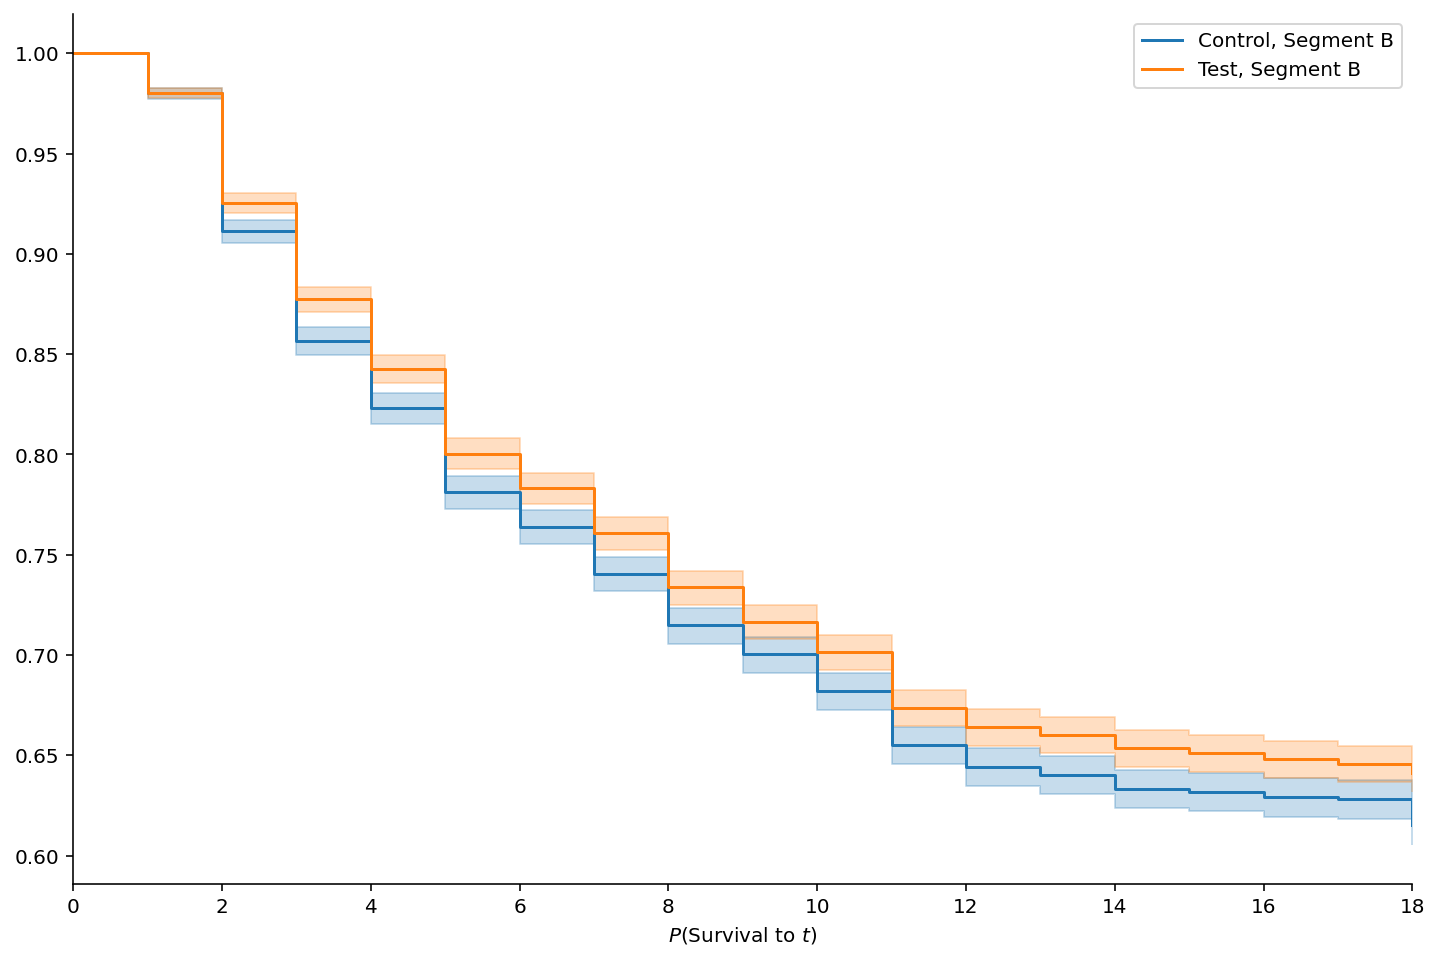

In [56]:
# Plot Test vs. Control retention overall
test_A_model = test_A.fit_survival_model('KaplanMeier', label='Test, Segment A')
control_A_model = control_A.fit_survival_model('KaplanMeier', label='Control, Segment A')
test_B_model = test_A.fit_survival_model('KaplanMeier', label='Test, Segment B')
control_B_model = control_A.fit_survival_model('KaplanMeier', label='Control, Segment B')

# Set up plots
plt.figure(figsize=(12,8)) 

# Plot data
# control_A_model.plot_survival_function()
# test_A_model.plot_survival_function()
control_B_model.plot_survival_function()
test_B_model.plot_survival_function()

# Cosmetic Adjustments
plt.xlabel('Months Since Conversion')
plt.xlabel('$P($Survival to $t)$')
plt.xlim(0, 18)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Member Value

From the case study prompt:

> To evaluate value to members, we look at what percentage of our members test the feature and continue to use it through time.
